# **Perceptron model to classify non-linearly separable data**

In this problem statement, the objective is to classify a given **non-linearly separable dataset using the MLP (Multi Layer Perceptron) model**. Simple perceptron cannot classify non-linearly separable data, it can only perform binary classification. The dataset consists of three distinct classes, each represented by two-dimensional feature vectors, with 500 data samples in both Class 1 and Class 2, and 1000 data samples in Class 3. **There is no need of a one-against-one (OAO) classification strategy** because of the following reasons:
- MLP (Multi-Layer Perceptron) can classify non-linearly separable data directly.
- It uses hidden layers and non-linear activation functions (like ReLU, sigmoid, or tanh) to create complex decision boundaries.
- MLP can handle multi-class classification naturally using a softmax output layer, eliminating the need for a one-against-one strategy.

Therefore, MLP does not require one-against-one classification for handling non-linearly separable data.

Furthermore, **the backpropagation algorithm will be implemented from scratch** for the aforementioned model to optimize its performance. This will involve computing gradients, updating model parameters iteratively, and ensuring effective learning within the perceptron framework.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [90]:
def load_data(path):
    return np.loadtxt(path)

# Load NLS dataset
class1_data = load_data('CS671_Dataset_Assignment1/Dataset-1/NLS/Class1.txt')
class2_data = load_data('CS671_Dataset_Assignment1/Dataset-1/NLS/Class2.txt')
class3_data = load_data('CS671_Dataset_Assignment1/Dataset-1/NLS/Class3.txt')
X = np.vstack((class1_data, class2_data, class3_data))
y = np.hstack((np.zeros(len(class1_data)), np.ones(len(class2_data)), 2*np.ones(len(class3_data))))
num_classes = 3
y_encoded = np.eye(num_classes)[y.astype(int)]
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y
)

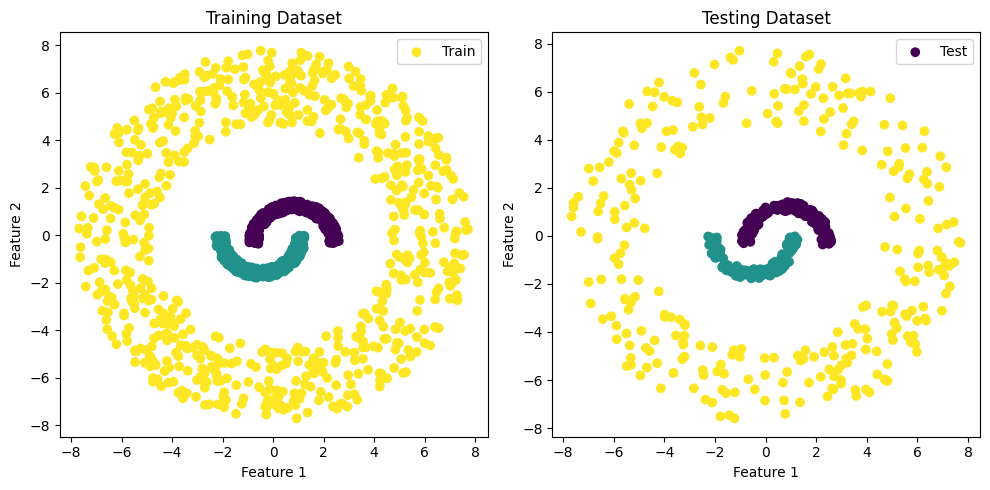

In [91]:

plt.figure(figsize=(10, 5))

# Plot Training Dataset
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=np.argmax(y_train, axis=1), cmap='viridis', label='Train')
plt.title('Training Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot Testing Dataset with corrected color mapping
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=np.argmax(y_test, axis=1), cmap='viridis', label='Test')  # Fix applied here
plt.title('Testing Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()


- **It is evident from the above plot that the given data is non-linearly separable.**
- The Perceptron Learning Algorithm (PLA) updates weights using a linear combination of input features.
- **This means it can only create a single straight-line decision boundary and cannot classify non-linear data**
- But non-linearly separable data needs curved or multiple boundaries, so we need to upgrade the model to a Multi-Layer Perceptron (MLP) with the Backpropagation algorithm.

In [92]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, activation='relu', learning_rate=0.01, epochs=1500):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.activation = activation
        self.loss_history = []
    
    def activation_function(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unsupported activation function")
    
    def activation_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'tanh':
            return 1 - np.tanh(x)**2
        elif self.activation == 'sigmoid':
            return self.activation_function(x) * (1 - self.activation_function(x))
        else:
            raise ValueError("Unsupported activation function")
    
    def forward(self, X):
        # Forward pass
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.activation_function(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.activation_function(self.Z2)
        return self.A2
    
    def compute_loss(self, y_true, y_pred):
        # Cross-entropy loss
        m = y_true.shape[0]
        epsilon = 1e-12
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
        return loss
    
    def backward(self, X, y_true, y_pred):
        # Backward pass
        m = X.shape[0]
        # Compute gradients
        dZ2 = y_pred - y_true  
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.activation_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        
        # Update weights and biases
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def train(self, X, y):
        for epoch in range(self.epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            self.backward(X, y, y_pred)
            self.loss_history.append(loss)
            
            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}")
    
    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)
    
    def predict_proba(self, X):
        return self.forward(X)


In [93]:
input_size = X_train.shape[1]
hidden_size = 4
output_size = num_classes
learning_rate = 0.01
epochs = 1500

mlp = MLP(input_size, hidden_size, output_size, activation='relu', learning_rate=learning_rate, epochs=epochs)

# Train
mlp.train(X_train, y_train)

Epoch 100/1500, Loss: 4.0790
Epoch 200/1500, Loss: 2.2703
Epoch 300/1500, Loss: 1.7092
Epoch 400/1500, Loss: 1.2453
Epoch 500/1500, Loss: 0.7709
Epoch 600/1500, Loss: 0.4514
Epoch 700/1500, Loss: 0.3478
Epoch 800/1500, Loss: 0.3171
Epoch 900/1500, Loss: 0.2968
Epoch 1000/1500, Loss: 0.2826
Epoch 1100/1500, Loss: 0.2719
Epoch 1200/1500, Loss: 0.2634
Epoch 1300/1500, Loss: 0.2562
Epoch 1400/1500, Loss: 0.2503
Epoch 1500/1500, Loss: 0.2453


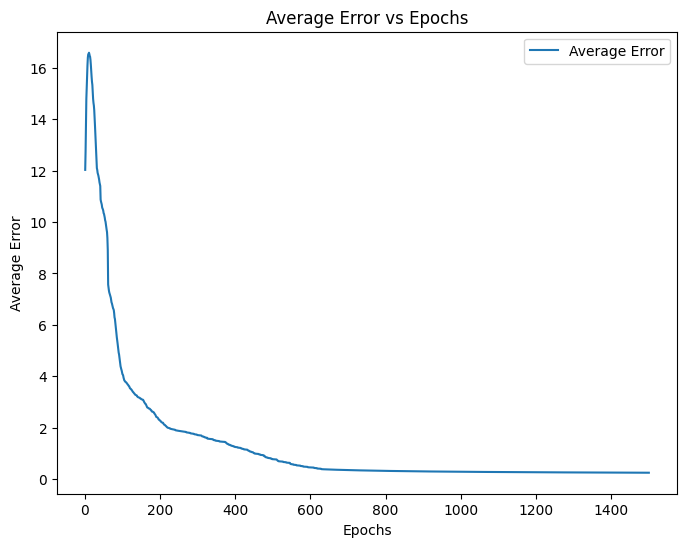

In [94]:
# Plot of Average Error vs Epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), mlp.loss_history, label='Average Error')
plt.title('Average Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Error')
plt.legend()
plt.show()

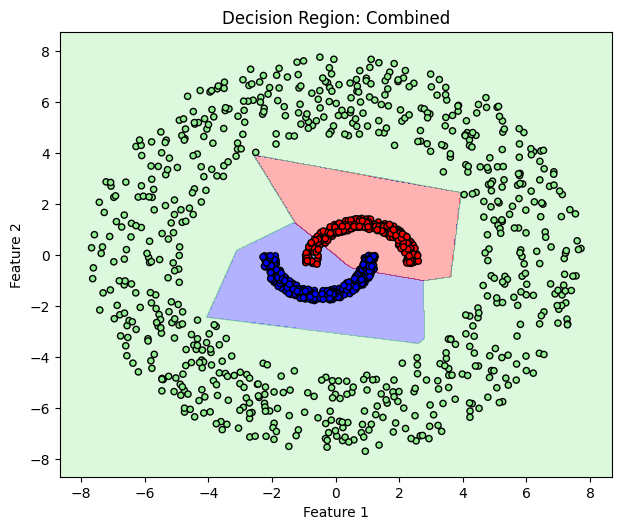

In [95]:
# Decision Region Plot
def plot_decision_regions(X, y, classifier, resolution=0.02, title=''):
    # Setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=cmap)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

plt.figure(figsize=(12,10))


plt.subplot(2, 2, 4)
plot_decision_regions(X_train, np.argmax(y_train, axis=1), mlp, title='Decision Region: Combined')
# plt.legend()

plt.tight_layout()
plt.show()

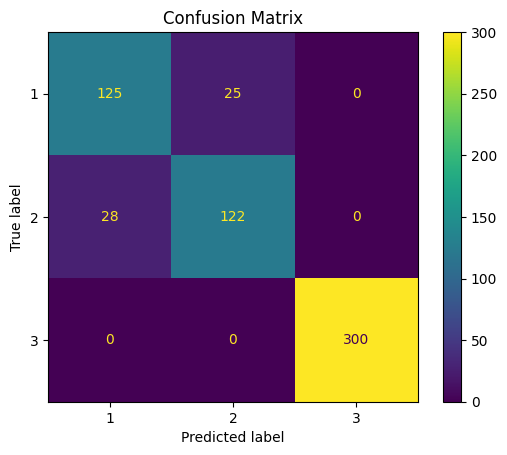

Classification Accuracy: 91.17%


In [96]:
y_pred_test = mlp.predict(X_test)
y_true_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_test, y_pred_test)
# print("Confusion Matrix:")
# print(cm)

disp = ConfusionMatrixDisplay(cm, display_labels=[1,2,3])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


accuracy = accuracy_score(y_true_test, y_pred_test)
print(f"Classification Accuracy: {accuracy:.2%}")